In [80]:
!pip install torchviz

In [81]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torchvision
import numpy as np
from torchviz import make_dot

In [3]:
torch.__version__

'2.5.1+cu121'

## load the MNIST dataset using datasets from torchvision

In [6]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)
val_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [7]:
train_data.data.size()

torch.Size([60000, 28, 28])

## visualize the train data

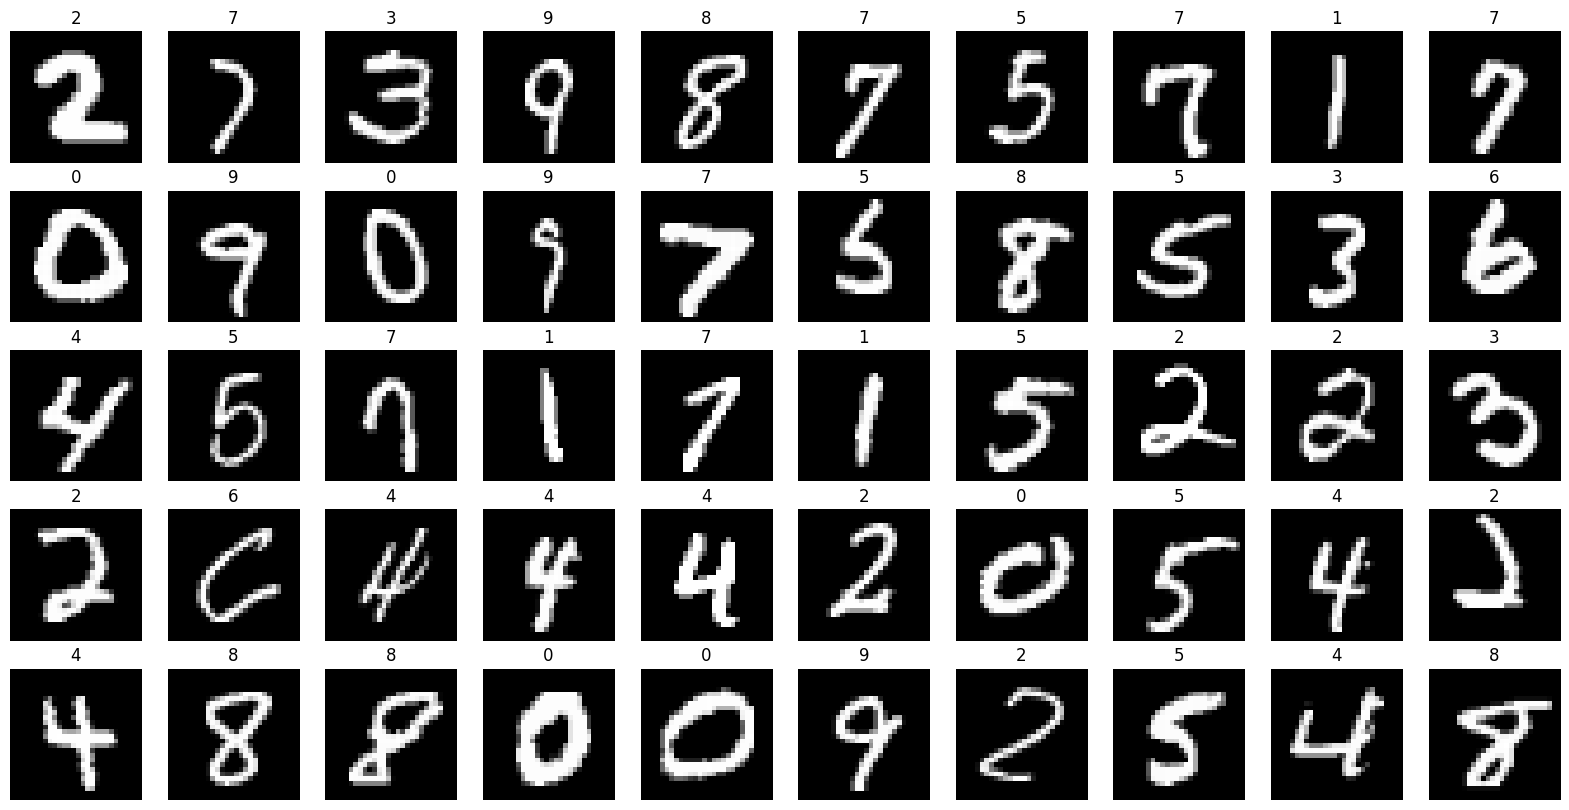

In [13]:
figure  = plt.figure(figsize=(20, 10))
cols, rows = 10, 5
for i in range(1,cols*rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [14]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

In [15]:
train_loader

## Create the CNN
I used 3 convolution layer each used one maxpool
and 2 fully connected layer used relu and softmax for prediction
I used maxpool after each Conv2d to get the invariance of translation so when the input is changed the output does not changed a lot
Also use 'same' convolution in layer 2 to preserve the input dimension and just expand the channel.

In [69]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(10,30, kernel_size = 3, padding = 1)
    self.pool2 = nn.MaxPool2d(3,1)
    self.conv3 = nn.Conv2d(30, 20, kernel_size=3)
    self.pool3 = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(320, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self,x):
    x = self.pool1(f.relu(self.conv1(x)))
    x = self.pool2(f.relu(self.conv2(x)))
    x = self.pool3(f.relu(self.conv3(x)))
    x = torch.flatten(x,1)
    x = f.relu(self.fc1(x))
    x = f.softmax(self.fc2(x))
    return x

## see architecture the network architecture

In [82]:
model = CNN()
dummy_input = torch.randn(1, 1, 28, 28)  # Batch size = 1, 1 channel, 28x28 input size

# Visualisasi model
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'  # Output format
dot.render('cnn_architecture')

<ipython-input-69-5c55b810d557>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))


'cnn_architecture.png'

In [70]:
print(CNN())

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(30, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


## set up the device

In [35]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


## Make train function and define the model

In [72]:
model = CNN().to(device)
optimizer= optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
loss_arr =[]

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):  # train using batch that we set in dataloader
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()# make sure zero gradient is set before backward
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()# backward props
        optimizer.step()# update the parameters
        loss_arr.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item()}')


def visualize_loss():
    plt.plot(loss_arr, label='Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Batches')
    plt.legend()
    plt.show()


## train the model and track loss during training

In [74]:
for epoch in range(1,11):
  train(epoch)



<ipython-input-69-5c55b810d557>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.6389235258102417
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.7303354740142822
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.6272809505462646
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.6664056777954102
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.7242634296417236
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.7225486040115356
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.632594347000122
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.7145819664001465
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.7189178466796875
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.550825834274292
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.5733755826950073
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.5731596946716309
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.5792696475982666
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.5719279050827026
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.6322795152664185
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.5425361394882202
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.58663690

Visualizing loss from the training

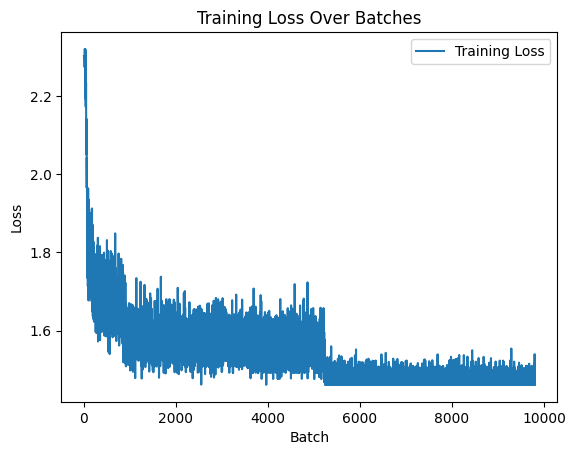

In [77]:
visualize_loss()

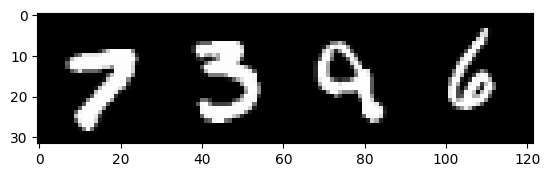

GroundTruth:  7     3     9     6    
Predicted:  7     3     9     6    


<ipython-input-34-5c55b810d557>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))


In [48]:
dataiter = iter(val_loader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
images = images.to(device)
labels = labels.to(device)
outputs = model(images[:4])
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

## evaluating model using val dataset

In [57]:
def test():
  correct = 0
  total = 0
  test_loss = 0
  with torch.no_grad():
    for data in val_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      test_loss += loss.item()
      _,predicted= torch.max(outputs,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f'Average Loss: {test_loss:.4f}')
  print(f'Accuracy of the network on the 10000 test images:{correct}/{len(val_loader.dataset)} ,{100 * correct // total} %\n')

In [58]:
test()

<ipython-input-34-5c55b810d557>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))


Average Loss: 231.5780
Accuracy of the network on the 10000 test images:9864/10000 ,98 %



It seems that my CNN is very good at classifying the hand written digits, we can see that from the accuracy we got here was 98%.

# See the model prediction for specific image

Prediction: 7


<ipython-input-34-5c55b810d557>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = f.softmax(self.fc2(x))


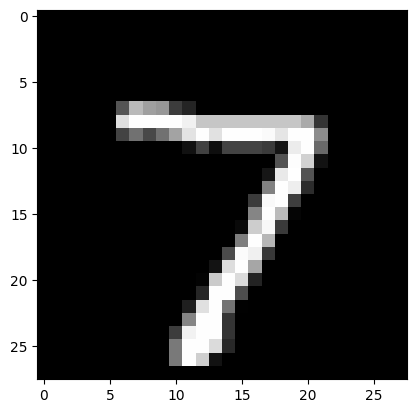

In [62]:
data, target = val_data[0]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True)
print(f'Prediction: {prediction.item()}')
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()